## Python Libraries Used Within Workbook

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
import scipy.linalg as la
import scipy.stats as st
import math
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Project Focus:
1. Fit a regression line to the provided data to estimate abalone age based on non-destructive physical attributes. 
<br>
2. Provide reasoning for multivariate techniques as well as assumptions on what makes them valid to use.

## Credentials

Data comes from an original study:

	Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and
	Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_
	species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North
	Coast and Islands of Bass Strait", Sea Fisheries Division, Technical
	Report No. 48 (ISSN 1034-3288)
    
Original owners of data:
    
	Marine Resources Division
	Marine Research Laboratories - Taroona
	Department of Primary Industry and Fisheries, Tasmania
	GPO Box 619F, Hobart, Tasmania 7001, Australia
	(contact: Warwick Nash +61 02 277277, wnash@dpi.tas.gov.au)

## First Glimpse of Data

The original data values have been scaled by 1/200 for their previous applications in ANN (artifical neural networks).

| Variable  | Data Type | Units | Description |
| :--- | :--- | :--- | :--- |
| Sex | Ordinal |	M, F, I | M = male, F = female, I = infant |
| Length | Continuous |	mm | longest shell measurement |
| Diameter | Continuous | mm | perpendicular to length |
| Height | Continuous | mm | with meat in shell |
| Whole weight | Continuous | grams | whole abalone |
| Shucked weight | Continuous | grams |weight of meat |
| Viscera weight | Continuous | grams | gut weight (after bleeding) |
| Shell weight | Continuous | grams | after being dried |
| Rings | Integer | | +1.5 gives the age in years |

   



In [3]:
# Import the .data file into a dataframe with column headers listed below.
Aba_data = pd.read_csv("abalone.data", names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight','Ring Count'])

# Next step is to separate the male, female, and infant abalone data to minimize confounding factors. 
# Invoking the "df.loc" method to return the separated abalone data based on sex to their new corresponding dataframes.  
Aba_data_male = Aba_data.loc[Aba_data['Sex'] == 'M']
Aba_data_female = Aba_data.loc[Aba_data['Sex'] == 'F']  
Aba_data_inf = Aba_data.loc[Aba_data['Sex'] == 'I']

# Dropping the "Sex" column within their respective dataframes to reduce redundant information.
Aba_data_male = Aba_data_male.drop(['Sex'], axis = 1)
Aba_data_female = Aba_data_female.drop(['Sex'], axis = 1)
Aba_data_inf = Aba_data_inf.drop(['Sex'], axis = 1)

# Resetting index starting at 0 enumerating until the last data point within respective dataframes making sure to not include the old segmented indices.
Aba_data_male = Aba_data_male.reset_index(drop = True)
Aba_data_female = Aba_data_female.reset_index(drop = True)
Aba_data_inf = Aba_data_inf.reset_index(drop = True)

# Non-destructive measurements are length, height, diameter, and weight. Removing the shucked, viscera, and shell weight data.
# Keeping the ring count as response variable.
Aba_data_male = Aba_data_male.drop(['Shucked Weight', 'Viscera Weight', 'Shell Weight'], axis = 1)
Aba_data_female = Aba_data_female.drop(['Shucked Weight', 'Viscera Weight', 'Shell Weight'], axis = 1)
Aba_data_inf = Aba_data_inf.drop(['Shucked Weight', 'Viscera Weight', 'Shell Weight'], axis = 1)

pred_col = ['Length', 'Diameter', 'Height', 'Whole Weight']

# Scaling up by 200 to restore the original values.
for col in pred_col:
    Aba_data_male[col] = Aba_data_male[col] * 200
    Aba_data_female[col] = Aba_data_female[col] * 200
    Aba_data_inf[col] = Aba_data_inf[col] * 200
    
display("Male Abalone Dataframe", Aba_data_male, "Female Abalone Dataframe",Aba_data_female, "Infant Abalone Dataframe", Aba_data_inf)

'Male Abalone Dataframe'

,Length,Diameter,Height,Whole Weight,Ring Count
0,91.0,73.0,19.0,102.8,15
1,70.0,53.0,18.0,45.1,7
2,88.0,73.0,25.0,103.2,10
3,95.0,74.0,25.0,101.9,9
4,86.0,70.0,22.0,81.2,10
...,...,...,...,...,...
1523,110.0,86.0,26.0,167.9,10
1524,112.0,86.0,31.0,173.5,8
1525,118.0,88.0,27.0,193.2,10
1526,120.0,95.0,41.0,235.2,9


'Female Abalone Dataframe'

,Length,Diameter,Height,Whole Weight,Ring Count
0,106.0,84.0,27.0,135.4,9
1,106.0,83.0,30.0,155.5,20
2,109.0,85.0,25.0,153.6,16
3,110.0,88.0,30.0,178.9,19
4,105.0,76.0,28.0,121.3,14
...,...,...,...,...,...
1302,117.0,95.0,33.0,210.6,11
1303,117.0,91.0,34.0,198.9,11
1304,103.0,80.0,25.0,123.0,8
1305,113.0,90.0,33.0,177.4,11


'Infant Abalone Dataframe'

,Length,Diameter,Height,Whole Weight,Ring Count
0,66.0,51.0,16.0,41.0,7
1,85.0,60.0,19.0,70.3,8
2,71.0,56.0,17.0,58.1,7
3,76.0,55.0,20.0,45.1,10
4,48.0,35.0,9.0,14.0,5
...,...,...,...,...,...
1337,96.0,71.0,22.0,89.9,8
1338,78.0,62.0,17.0,68.8,7
1339,78.0,58.0,20.0,56.9,7
1340,81.0,60.0,17.0,60.7,7


## Descriptive Statistics for Length, Diameter, Height, Whole Weight, and Ring Count

Calculate sample mean, sample variance, interquartile range, and correlation coefficient for physical attribute variables.
<br>
I'll create tables, and graphics to explore the data set.

#### Sample Mean for Length, Diameter, Height, Whole Weight, and Ring Count.

In [4]:
# Incredibly easy method to invoke is the "df.mean()".
# Returns the mean of each column as a Panda Series.
Aba_data_male_mean = Aba_data_male.mean(axis = 0)
Aba_data_female_mean = Aba_data_female.mean(axis = 0)
Aba_data_inf_mean = Aba_data_inf.mean(axis = 0)

display("Male Abalone Means", Aba_data_male_mean, "Female Abalone Means", Aba_data_female_mean, "Infant Abalone Means", Aba_data_inf_mean) 


'Male Abalone Means'

Length          112.278141
Diameter         87.857330
Height           30.276178
Whole Weight    198.291885
Ring Count       10.705497
dtype: float64

'Female Abalone Means'

Length          115.818669
Diameter         90.946442
Height           31.602142
Whole Weight    209.306427
Ring Count       11.129304
dtype: float64

'Infant Abalone Means'

Length          85.549180
Diameter        65.298808
Height          21.599106
Whole Weight    86.272504
Ring Count       7.890462
dtype: float64

#### Sample standard deviation for Length, Diameter, Height, Whole Weight, and Ring Count.

In [5]:
# Using a similar method but for standard deviation, "df.std()".
Aba_data_male_std = Aba_data_male.std(axis = 0)
Aba_data_female_std = Aba_data_female.std(axis = 0)
Aba_data_inf_std = Aba_data_inf.std(axis = 0)

display("Male Abalone Std. Dev.'s", Aba_data_male_std, "Female Abalone Std. Dev.'s", Aba_data_female_std, "Infant Abalone Std. Dev.'s", Aba_data_inf_std) 

"Male Abalone Std. Dev.'s"

Length          20.539463
Diameter        16.879613
Height           6.960900
Whole Weight    94.116275
Ring Count       3.026349
dtype: float64

"Female Abalone Std. Dev.'s"

Length          17.231911
Diameter        14.190841
Height           7.996798
Whole Weight    86.063263
Ring Count       3.104256
dtype: float64

"Infant Abalone Std. Dev.'s"

Length          21.771545
Diameter        17.621786
Height           6.399007
Whole Weight    57.254932
Ring Count       2.511554
dtype: float64

#### Sample variance for Length, Diameter, Height, Whole Weight, and Ring Count.

In [6]:
# I already have the standard deviation for each variable, squaring them will provide me with the sample variances as well.
# I'm invoking the numpy power method that passes in a series or list and raises all the entries to the second power.
Aba_data_male_var = np.power(Aba_data_male_std, 2)
Aba_data_female_var = np.power(Aba_data_female_std, 2)
Aba_data_inf_var = np.power(Aba_data_inf_std, 2)

display("Male Abalone Variances", Aba_data_male_var, "Female Abalone Variances", Aba_data_female_var, "Infant Abalone Variances", Aba_data_inf_var )

'Male Abalone Variances'

Length           421.869542
Diameter         284.921348
Height            48.454128
Whole Weight    8857.873163
Ring Count         9.158791
dtype: float64

'Female Abalone Variances'

Length           296.938763
Diameter         201.379978
Height            63.948786
Whole Weight    7406.885165
Ring Count         9.636407
dtype: float64

'Infant Abalone Variances'

Length           474.000189
Diameter         310.527351
Height            40.947292
Whole Weight    3278.127290
Ring Count         6.307903
dtype: float64

#### First Quartile, Median (Second Quartile), Third Quartile, and Interquartile Range with Outliers.

In [7]:
# There are a few ways to calculate the quartiles, but I'm going to use a method that inputs a percentile.
# Reminder that the first quartile is the 25th percentile; similarly for the second and third corresponds to the 50th and 75th percentile.
q1_male = np.percentile(Aba_data_male['Length'], q = 50, axis = 0, interpolation = 'midpoint')

# Here I'm creating a summary table for the quartiles, interquartile range, minimum (Q1-1.5*IQR), maximum (Q3+1.5*IQR).
qrt_male = pd.DataFrame(index = ['Q1', 'Q2', 'Q3', 'IQR',  'Minimum', 'Maximum'], columns = Aba_data_male.columns)
qrt_female = pd.DataFrame(index = ['Q1', 'Q2', 'Q3', 'IQR', 'Minimum', 'Maximum'], columns = Aba_data_male.columns)
qrt_inf = pd.DataFrame(index = ['Q1', 'Q2', 'Q3', 'IQR', 'Minimum', 'Maximum'], columns = Aba_data_male.columns)


# Extracting header from the male abalone data column headers that can be used for quartile summary algorithm.
var_list = list(Aba_data_male.columns)

# Percentile values list.
pct_list = [('Q1', 25), ('Q2', 50), ('Q3', 75), ('Minimum', 0), ('Maximum', 100)]

# Looping through the columns of each abalone dataframe computing the Q1, Q2, Q3, Minimum, and Maximum.
# I'm defining the Min, Max as the 0th percentile and 100th percentile.
for var in var_list:
    for qrt, pct in pct_list:
       
        qrt_male_val = np.percentile(Aba_data_male[var], q = int(pct), axis = 0, interpolation = 'midpoint')
        qrt_male.loc[qrt, var] = qrt_male_val
        
        qrt_female_val = np.percentile(Aba_data_female[var], q = int(pct), axis = 0, interpolation = 'midpoint')
        qrt_female.loc[qrt, var] = qrt_female_val
        
        qrt_inf_val = np.percentile(Aba_data_inf[var], q = int(pct), axis = 0, interpolation = 'midpoint')
        qrt_inf.loc[qrt, var] = qrt_inf_val     

# Computing interquartile range. 
for var in var_list:
    qrt_male.loc['IQR', var] = qrt_male.loc['Q3', var] - qrt_male.loc['Q1', var]
    qrt_female.loc['IQR', var] = qrt_female.loc['Q3', var] - qrt_female.loc['Q1', var]
    qrt_inf.loc['IQR', var] = qrt_inf.loc['Q3', var] - qrt_inf.loc['Q1', var]

display("Male Abalone 5 Number Summary", qrt_male, "Female Abalone 5 Number Summary", qrt_female, "Infant Abalone 5 Number Summary", qrt_inf)

'Male Abalone 5 Number Summary'

,Length,Diameter,Height,Whole Weight,Ring Count
Q1,101,79,26,134.15,9
Q2,116,91,31,195.15,10
Q3,126,100,35,253.15,12
IQR,25,21,9,119,3
Minimum,31,22,5,3.1,3
Maximum,156,126,103,565.1,27


'Female Abalone 5 Number Summary'

,Length,Diameter,Height,Whole Weight,Ring Count
Q1,105,82,28,146,9
Q2,118,93,32,207.7,10
Q3,128,101,35,264.05,12
IQR,23,19,7,118.05,3
Minimum,55,39,3,16,5
Maximum,163,130,226,531.4,29


'Infant Abalone 5 Number Summary'

,Length,Diameter,Height,Whole Weight,Ring Count
Q1,72,54,17,41.1,6
Q2,87,67,22,76.8,8
Q3,102,78,26,119.85,9
IQR,30,24,9,78.75,3
Minimum,15,11,0,0.4,1
Maximum,145,110,44,409.9,21


#### Male Abalone Physical Attributes Boxplots

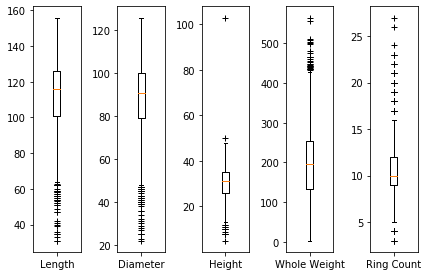

In [8]:
# Place 5 plots for each variable. 
fig, axs = plt.subplots(1, 5)

#fig = plt.figure(figsize = (6, 3))

# Improve spacing of boxplots using the method below.
fig.tight_layout()

# Converting columns within the male abalone data to list.
len_male = Aba_data_male['Length'].tolist()
dia_male = Aba_data_male['Diameter'].tolist()
ht_male = Aba_data_male['Height'].tolist()
wt_male = Aba_data_male['Whole Weight'].tolist()
ring_male = Aba_data_male['Ring Count'].tolist()

axs[0].boxplot(len_male, 0, 'k+', showfliers = True, labels = ['Length'])
axs[1].boxplot(dia_male, 0, 'k+', showfliers = True, labels = ['Diameter'])
axs[2].boxplot(ht_male, 0, 'k+', showfliers = True, labels = ['Height'])
axs[3].boxplot(wt_male, 0, 'k+', showfliers = True, labels = ['Whole Weight'])
axs[4].boxplot(ring_male, 0, 'k+', showfliers = True, labels = ['Ring Count'])
plt.show()

#### Female Abalone Physical Attributes Boxplots

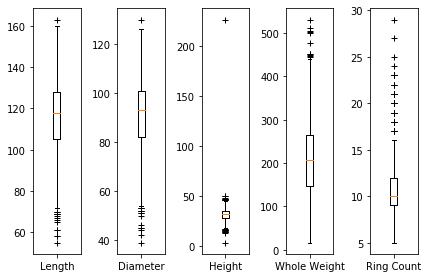

In [9]:
# Place 5 plots for each variable. 
fig, axs = plt.subplots(1, 5)

# Improve spacing of boxplots using the method below.
fig.tight_layout()

# Converting columns within the female abalone data to list.
len_female = Aba_data_female['Length'].tolist()
dia_female = Aba_data_female['Diameter'].tolist()
ht_female = Aba_data_female['Height'].tolist()
wt_female = Aba_data_female['Whole Weight'].tolist()
ring_female = Aba_data_female['Ring Count'].tolist()

axs[0].boxplot(len_female, 0, 'k+', showfliers = True, labels = ['Length'])
axs[1].boxplot(dia_female, 0, 'k+', showfliers = True, labels = ['Diameter'])
axs[2].boxplot(ht_female, 0, 'k+', showfliers = True, labels = ['Height'])
axs[3].boxplot(wt_female, 0, 'k+', showfliers = True, labels = ['Whole Weight'])
axs[4].boxplot(ring_female, 0, 'k+', showfliers = True, labels = ['Ring Count'])

plt.show()

#### Infant Abalone Physical Attributes Boxplots

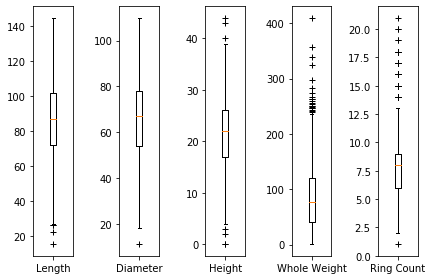

In [10]:
# Place 5 plots for each variable. 
fig, axs = plt.subplots(1, 5)

#plt.suptitle('Infant Abalone Boxplots')

# Converting columns within the infant abalone data to list.
len_inf = Aba_data_inf['Length'].tolist()
dia_inf = Aba_data_inf['Diameter'].tolist()
ht_inf = Aba_data_inf['Height'].tolist()
wt_inf = Aba_data_inf['Whole Weight'].tolist()
ring_inf = Aba_data_inf['Ring Count'].tolist()

axs[0].boxplot(len_inf, 0,'k+', showfliers = True, labels = ['Length'])
axs[1].boxplot(dia_inf, 0,'k+', showfliers = True, labels = ['Diameter'])
axs[2].boxplot(ht_inf, 0,'k+', showfliers = True, labels = ['Height'])
axs[3].boxplot(wt_inf, 0,'k+', showfliers = True, labels = ['Whole Weight'])
axs[4].boxplot(ring_inf, 0,'k+', showfliers = True, labels = ['Ring Count'])

# Improve spacing of boxplots using the method below.
fig.tight_layout()

plt.show()

Inspecting the 5 number summary table and boxplots for infant abalone, the ring count stands out as odd. According to the 128th fisheries report published in 2001 by the Australian Department of Fisheries, black lip abalone has a maturation age of 3 years. The ring count boxplot for the infant data shows spread from 1 to over 20 rings with half of the data between 6 to 9 rings. The abalone age is add 1.5 to the number of rings. Working backwards here starting with age to ring count, a mature black lip abalone is 1.5 rings. Destructive methods and an additional study would need to be undertaken to estimate age on width between rings, so I will conservatively round down on ring count making an infant black lip abalone having less than 2 rings.
<br>
Using the biology of the abalone as justification, I will discard observations within the infant dataframe with less than 2 rings.

In [11]:
display(Aba_data_inf[Aba_data_inf['Ring Count'] < 2])

,Length,Diameter,Height,Whole Weight,Ring Count
39,15.0,11.0,2.0,0.4,1


The returned dataframe for infant abalone with a conditional operator for less than 2 ring count contains a singular entry. There is something suspicious about this data set or my understanding of the "infant" designation is flawed. I will rely on the biology as a foundation for decision making in this case and not use the infant data set because there is only one data point.
<br>

I would like to now combine the female and male abalone data into one for a single regression analysis, but is that appropriate to do so? Is there a statistical tool to examine if female abalone are different enough from male abalone in terms of physical features requiring two separate regressions?
<br>

A test of two population means comes to mind with the assumption of unequal variances to determine if male and female abalone physical features are different from each other. I'll be using a non-pooled t-Test with the assumptions that the abalones were simply randomly selected and that the selection of abalone were free of influence from previous choices. With the practical application of the Central Limit Theorem, and a healthy sample size of one thousand plus, the normal assumption is fulfilled.

#### Non-Pooled t-Test (Welch's t-Test)

The null hypothesis: mean male abalone physical feature is equal to that of their female counterpoint.
<br>
The alternative hypothesis: mean male abalone physical feature is not equal to that of their female counterpoint.
<br> 

$\alpha$-level = 5%
<br>

If $p$ $\leq$ $\alpha$, reject null hypothesis.

In [12]:
tt_results = pd.DataFrame(index = var_list, columns = ['t-Statistic', 'p-value'])

for var in var_list:
    t_stat, p_val = st.ttest_ind(Aba_data_male[var], Aba_data_female[var], equal_var = False)
    tt_results.loc[var] = t_stat, p_val

display(tt_results)

,t-Statistic,p-value
Length,-4.9907,6.38015e-07
Diameter,-5.29354,1.29146e-07
Height,-4.66939,3.17388e-06
Whole Weight,-3.25309,0.00115504
Ring Count,-3.66566,0.000251381


The table summarizes the t-Statistic, and p-values for the physical features. The returned p-values say to reject the null hypothesis for all features; simply said, female abalone differ in size and age from males. Looking at the mean summary values between male and female abalone, the female abalone are, on average, larger than their male counterparts.
<br>

With the information provided so far, I will run a regression on male and female abalone separately.

#### Variable Correlation by Sex

Plotting a matrix of scatterplots exhibits the general relationship predictor variables have with one another. This graphical method is a great way to quickly and easily assess relationships visually. The histograms are inserted into the diagonal entries of the matrix of graphs to replace redundant information.

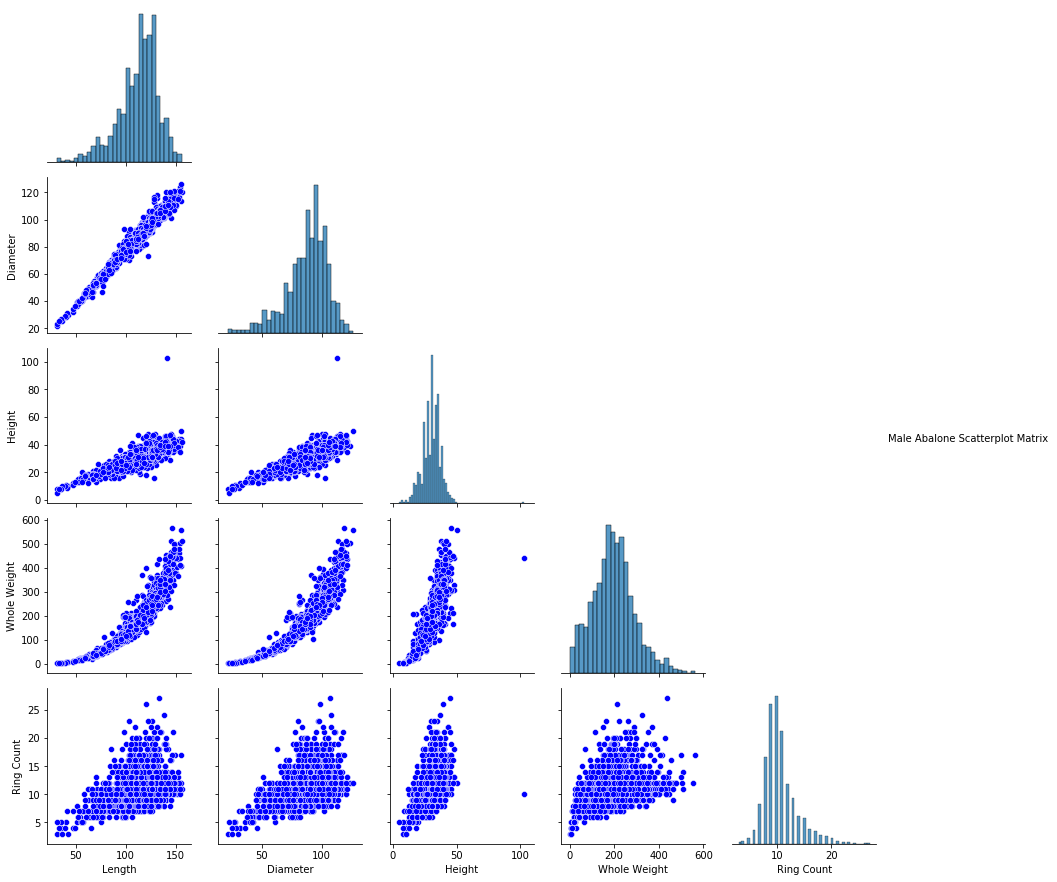

In [13]:
# PairGrid method is used to quickly assess relationships among the variables by way of scatter and kernel density estimate plots.
pgs_male = sns.PairGrid(Aba_data_male, diag_sharey=False, corner=True)
pgs_male.map_diag(sns.histplot)
pgs_male.map_lower(sns.scatterplot, color = 'blue')
pgs_male.add_legend(title = "Male Abalone Scatterplot Matrix")
plt.show()

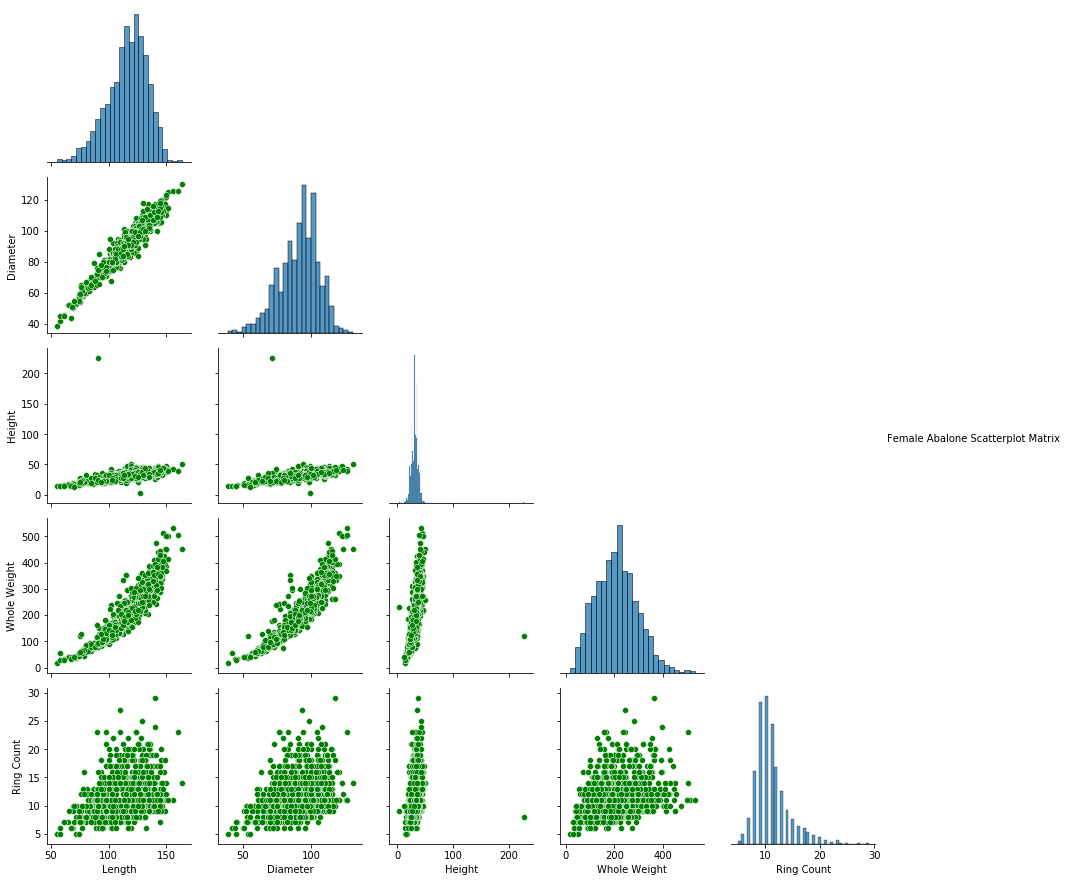

In [14]:
pgs_female = sns.PairGrid(Aba_data_female, diag_sharey=False, corner=True)
pgs_female.map_diag(sns.histplot)
pgs_female.map_lower(sns.scatterplot, color = 'green')
pgs_female.add_legend(title = "Female Abalone Scatterplot Matrix")
plt.show()

The matrix of scatter plot shows strong linear relationship between height, diameter, length, and weight for both sexes. This would indicate collinearity between the predictor variables. There is a quadratic relationship with length and weight, and diameter and weight. The important relationship I am after is between ring count and the predictor variables. Judging the plots with the naked eye, it's possible that there is a linear relationship with high amount of variability in two directions between ring count and the predictor variables. A single observation for both the male and female abalone for ring count compared to height stands out. This observation will need further assessment regarding its impact on the regression. Visually seeing relationships is subjective, so I will need to numerically determine relationships by way of a heatmap and correlation coefficient.

#### Correlation Coefficient Matrix and Heatmap

An entire data column like length and diameter can be considered their own vectors in vector space. Correlation in vector space is the measure of the cosined angle between the two vectors. It is a number that describes how strongly the two vectors follow a linear relationship. The correlation coefficient vary from -1 to +1. Two vectors pointing in the same direction parallel is the +1 case while the -1 case corresponds to two vectors parallel, but directionally opposed. 
<br>

An intuitive way to think about correlation between two vectors is if I change 1 unit of let say, the length vector, how much does the diameter change? If a 1 unit change to length corresponds to 1 unit change in diameter, then the vectors have perfect correlation of 1. If its a 1 unit change to length corresponds to -1 unit change in diameter, then the vectors have perfect correlation of -1. If there is no change, then they are uncorrelated.
<br>

The heatmaps annotated with the correlation coefficient $r$ shows the strength of linear relationships among the predictor variables by number and depth of color.

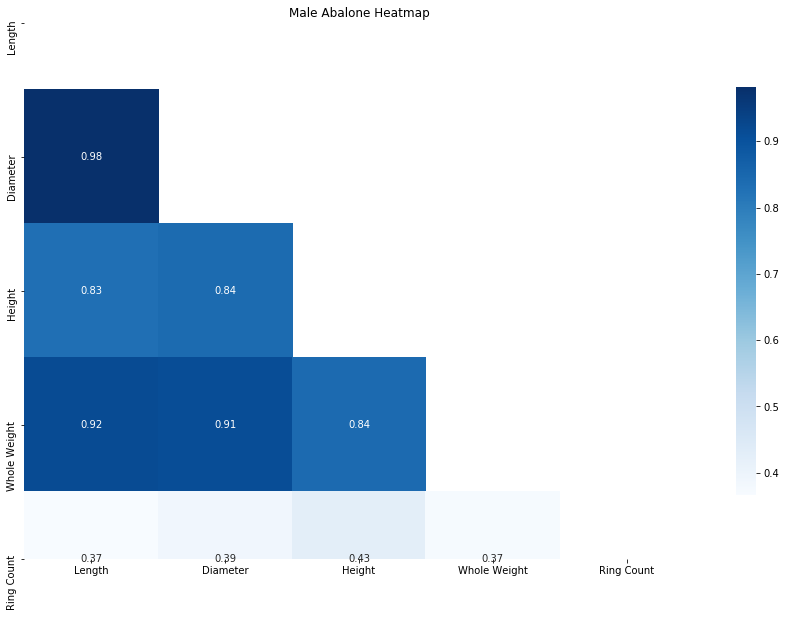

In [15]:
# Produce heatmap and numerical correlation value, r.
corr_male = Aba_data_male.corr()
mask_male = np.triu(np.ones_like(corr_male, dtype = bool))

# Sizing the heatmap plots.
f, ax = plt.subplots(figsize = (15, 15))
cmap = sns.diverging_palette(250, 15, as_cmap=True)

sns.heatmap(corr_male, mask = mask_male, cmap = 'Blues', square = True, annot = True, cbar_kws = {"shrink": .5}).set_title('Male Abalone Heatmap')
plt.show()

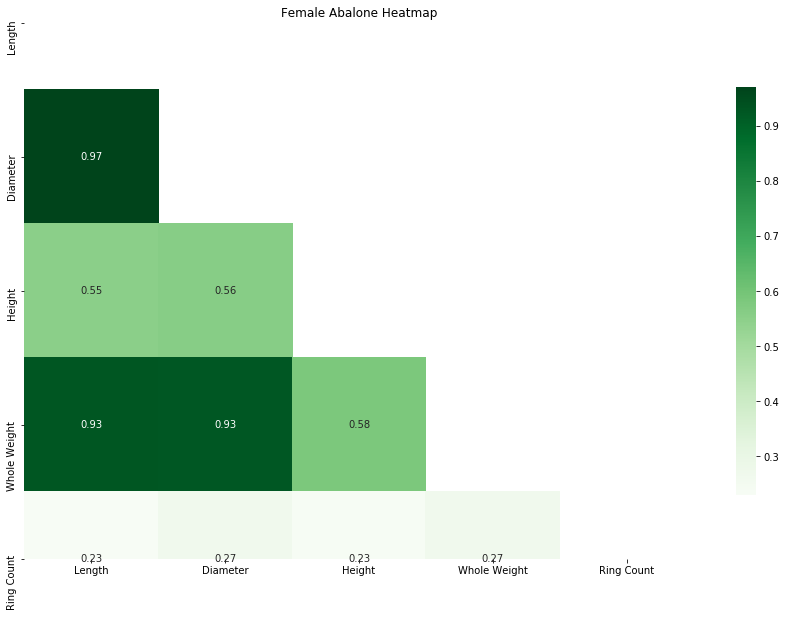

In [16]:
corr_female = Aba_data_female.corr()
mask_female = np.triu(np.ones_like(corr_male, dtype = bool))

f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(250, 15, as_cmap=True)

sns.heatmap(corr_female, mask = mask_female, cmap = 'Greens', square = True, annot = True, cbar_kws = {"shrink": .5}).set_title('Female Abalone Heatmap')
plt.show()

## Principal Component Analysis - Ordinary Least Squares Regression

The matrix of scatterplots shows tight clustering that can be encapsulated by an football shaped outline (ellipsoid) along with the correlation heatmap matrix indicate multicollinearity among the predictor variables. I will need to determine the Variance Inflated Factors, VIF's for short, that will numerically describe how the independent predictor variables affect one another. VIF values are the amount of variance of a particular predictor variable relative to the total variance. It's a method to determine how severely the predictor variables are intertwined.
<br>

VIF values of less than or equal to 1, VIF $\leq 1$, means that the $i^{th}$ predictor variable has little to no multicollinearity with the remaining predictor variables.
<br>

VIF values between 1 and 5, $1 <$ VIF $\leq 5$, means that the $i^{th}$ predictor variable is moderately multicollineated with the remaining predictor variables.
<br>

VIF values greater than 5,  VIF $> 5$, means that the $i^{th}$ predictor variable is severely multicollineated with the remaining predictor variables.
<br>

In [17]:
# Create dataframes that are used as matrices to run correlation coefficient calculations.
VIF_mpvar = Aba_data_male[['Length', 'Diameter','Height', 'Whole Weight']]
corr_mres = np.corrcoef(VIF_mpvar, rowvar = False)

# Take the inverse and return the diagonals which give the Coefficient of Determination, r^2.
VIF_male = np.linalg.inv(corr_mres)
VIF_fpvar = Aba_data_female[['Length', 'Diameter','Height', 'Whole Weight']]

corr_fres = np.corrcoef(VIF_fpvar, rowvar = False)
VIF_female = np.linalg.inv(corr_fres)
 
display("Male Abalone VIF", VIF_male.diagonal(), "Female Abalone VIF", VIF_female.diagonal())

'Male Abalone VIF'

array([30.30347338, 29.52141648,  3.86176641,  7.35796752])

'Female Abalone VIF'

array([19.77714403, 18.95648111,  1.52612151,  8.19794695])

The returned arrays contain the VIF values that indicate length, diameter, height and whole weight for both male and female abalone are multicollineated meaning shifts in any predictor variables could lead to changes in the other. I need to find a method to uncorrelate the predictor variables before running ordinary least squares regression.
<br>

Principal Component Analysis is the solution to the problem. It will untangle the predictor variables, reduce the dimensionality of the data set in terms of numerical entries, and project its vector space to a lower dimension while still retaining the information of the original data. Coupling Principal Component Analysis and Ordinary Least Squares regression, I can estimate the best fit line with fewer inputs. This technique is called Principal Component Regression.

#### Principal Component Analysis

PCA views the original data set as a vector space and transforms it to a possibly lower dimensional space that can be outlined by an ellipsoid with major and minor axes defined by the eigenvectors of the vector space of the original data. Each axes has a corresponding scaling factor (think "tick marks of an axes") that represents a fraction of the total variance (information) within the original data. Since the axes are perpendicular to one another, they are uncorrelated, it's possible to resolve the multicollinearity issues found within the data set determined visually by the scatter plots, and computationally by the correlation coefficient $r$. 


#### Forming the Covariance Matrix and Standardized Design Matrix.

In [18]:
# Form the covariance matrix by XTX or XXT depending how the data is structured to reduce 1000+ by 4 matrix to a 4 by 4 square matrix.
pca_male = Aba_data_male[['Length', 'Diameter', 'Height', 'Whole Weight']] 

pca_var = ['Length', 'Diameter', 'Height', 'Whole Weight']

# Standardizing design matrix (original data set) by mean centering and scaling by the respective standard deviations because the units are mixed. Grams for weights and mm for length.
# After standardizing, the computations are done with changes in data instead of their respective units of measure.
z_mpca = pd.DataFrame(index = Aba_data_male.index, columns = ['Length', 'Diameter', 'Height', 'Whole Weight'])
z_fpca = pd.DataFrame(index = Aba_data_female.index, columns = ['Length', 'Diameter', 'Height', 'Whole Weight'])

for pc in pca_var:
    for i in z_mpca.index:
        z_mpca.loc[i, pc] = (Aba_data_male.loc[i, pc] - Aba_data_male[pc].mean()) / Aba_data_male[pc].std()

for pc in pca_var:
    for i in z_fpca.index:
        z_fpca.loc[i, pc] = (Aba_data_female.loc[i, pc] - Aba_data_female[pc].mean()) / Aba_data_female[pc].std()        

# the method "df.cov()"will input a data matrix, standardize it then compute the covariance matrix by means of X @ X.T or X.T @ X.
cov_m = pca_male.cov()

pca_female = Aba_data_female[['Length', 'Diameter', 'Height', 'Whole Weight']]
cov_f = pca_female.cov()

display("Standardized Male Data", z_mpca, "Standardized Female Data", z_fpca)
display("Male Abalone Covariance Matrix", cov_m, "Female Abalone Covariance Matrix", cov_f)

'Standardized Male Data'

,Length,Diameter,Height,Whole Weight
0,-1.03596,-0.880194,-1.61993,-1.01462
1,-2.05839,-2.06505,-1.76359,-1.62769
2,-1.18202,-0.880194,-0.757974,-1.01037
3,-0.841217,-0.820951,-0.757974,-1.02418
4,-1.2794,-1.05792,-1.18895,-1.24412
...,...,...,...,...
1523,-0.110915,-0.110034,-0.614314,-0.322918
1524,-0.0135418,-0.110034,0.103984,-0.263418
1525,0.278579,0.00845222,-0.470654,-0.0541021
1526,0.375952,0.423154,1.54058,0.392154


'Standardized Female Data'

,Length,Diameter,Height,Whole Weight
0,-0.569796,-0.489502,-0.575498,-0.858745
1,-0.569796,-0.55997,-0.200348,-0.625196
2,-0.3957,-0.419034,-0.825598,-0.647273
3,-0.337668,-0.20763,-0.200348,-0.353303
4,-0.627828,-1.05325,-0.450448,-1.02258
...,...,...,...,...
1302,0.0685549,0.285646,0.174802,0.0150305
1303,0.0685549,0.00377411,0.299852,-0.120916
1304,-0.743891,-0.771374,-0.825598,-1.00283
1305,-0.163573,-0.0666939,0.174802,-0.370732


'Male Abalone Covariance Matrix'

,Length,Diameter,Height,Whole Weight
Length,421.869542,340.425432,119.042321,1775.148886
Diameter,340.425432,284.921348,98.791884,1450.637676
Height,119.042321,98.791884,48.454128,552.140946
Whole Weight,1775.148886,1450.637676,552.140946,8857.873163


'Female Abalone Covariance Matrix'

,Length,Diameter,Height,Whole Weight
Length,296.938763,237.463481,76.271599,1377.911273
Diameter,237.463481,201.379978,63.793377,1130.494755
Height,76.271599,63.793377,63.948786,401.752559
Whole Weight,1377.911273,1130.494755,401.752559,7406.885165


The diagonal entries represent the variance of each predictor variable of itself while the off-diagonal entries are the covariances between the predictor variables. The diagonal entries of both covariance matrices match the values for male and female abalone variances when I calculated them individually as descriptive statistics. A good sign.

#### Computing Principal Components

In [19]:
# Initializing empty total Variance for male and female abalone data.
total_mvar = 0
total_fvar = 0

# Initializing empty list to store proportional variance corresponding to their principal axes.
mpca_varpct = []
fpca_varpct = []

# Project the entire data space onto a line to determine the principal axes (eigenvectors) and scaling factors (eigenvalues).
eig_m, eigv_m = la.eig(cov_m)
eig_f, eigv_f = la.eig(cov_f)

# The returned eigenvectors of the covariance matrix that correspond to the largest variance represents the original data matrix but in a drastically reduced fashion.
for lam in eig_m:
    total_mvar += lam

# Computing proportion of variance corresponding to each principal component.    
for lam in eig_m:
    mpca_varpct.append(lam/total_mvar)

for lam in eig_f:
    total_fvar += lam
    
for lam in eig_f:
    fpca_varpct.append(lam/total_fvar)

#display(eigv_m[:, 0], eigv_f[:, 0])    

# Output the eigenvalues, eigenvectors, and the variance contributed proportionally.   
display("Eigenvalues - Female Abalone", eig_f.real, "Eigenvectors (Column Vectors) - Female Abalone", eigv_f.round(8), "% Variance Captured by Eigvenctor",fpca_varpct)

# Output the eigenvalues, eigenvectors, and the variance contributed proportionally.
display("Eigenvalues - Male Abalone", eig_m.real, "Eigenvectors (Column Vectors) - Male Abalone", eigv_m,"% Variance Captured by Eigvenctor", mpca_varpct)

'Eigenvalues - Female Abalone'

array([7.86117891e+03, 6.90687589e+00, 5.92709194e+01, 4.17959861e+01])

'Eigenvectors (Column Vectors) - Female Abalone'

array([[ 1.8200008e-01, -6.2647121e-01,  7.4986509e-01,  1.1005518e-01],
       [ 1.4931047e-01,  7.7896116e-01,  6.0667395e-01,  5.3596750e-02],
       [ 5.3004360e-02, -2.7433560e-02,  1.0983157e-01, -9.9215672e-01],
       [ 9.7044984e-01, -8.6058000e-04, -2.3997101e-01,  2.5303750e-02]])

'% Variance Captured by Eigvenctor'

[(0.9864510336859188+0j),
 (0.0008667014124154765+0j),
 (0.007437543450576533+0j),
 (0.005244721451089338+0j)]

'Eigenvalues - Male Abalone'

array([9.49280055e+03, 1.01613782e+02, 5.97034494e+00, 1.27335070e+01])

'Eigenvectors (Column Vectors) - Male Abalone'

array([[ 0.19576651,  0.73777408, -0.61542303, -0.1965181 ],
       [ 0.16001276,  0.61380478,  0.77162146,  0.04732784],
       [ 0.06059334,  0.11066972, -0.16064256,  0.97891503],
       [ 0.96560853, -0.25823498,  0.006984  , -0.02942924]])

'% Variance Captured by Eigvenctor'

[(0.9874840159039444+0j),
 (0.010570324880077775+0j),
 (0.0006210622644110021+0j),
 (0.001324596951566779+0j)]

#### Selecting Principal Components

Picking and choosing which principal components to keep or discard is contextualized by the purpose of doing PCA, the data set, and question(s) that's trying to be answered. For this study, I wanted to uncorrelate the predictor variables while retaining as much information as possible. A common method is to plot the Root Mean Squares Error as the number of principal components increases until the scree plot reaches a minimum, or "levels out". The PCA results indicate the first principal component captures over 98% of all the data that is described by a linear combination of 4 predictor variables. I will forgo the scree plot and keep only the first principal component since the next largest principal component contributes an additional 1% of the information. I have now reduced 4 variables to 1.
<br>

Another way to think about it is there are 1528 and 1307 data points within the male and female dataframes respectively. If I have 4 predictor variables for each dataframe, the total amount of information stored is 6,112, and 5,288 elements. Using PCA and keeping only the first component, I have reduced the total number of elements by 4 fold.

#### Recasting Original Data via PC1

Now that I have the eigenvectors of the original data, it's time to transform them into an equivalent representation that has fewer variables. The resulting recast yields 1 value that is an equivalent representation of the linear combinations of the 4 original predictor variables of length, diameter, height, and whole weight!

In [20]:
# Rerepresenting the original data set by a reduced linear combination equivalent based on the first Principal Component acting as the scalar weights multiplied with the predictor variables.
X_fpca = pd.Series(z_fpca @ eigv_f[:, 0]) 
X_mpca = pd.Series(z_mpca @ eigv_m[:, 0])

# Create design matrix for OLS regression.
X_mreg = pd.DataFrame(index = X_mpca.index, columns = ['Ones', 'X_mpca'])
X_freg = pd.DataFrame(index = X_fpca.index, columns = ['Ones', 'X_fpca'])

# Populating the "ones" column with "1's".
X_mreg['Ones'] = 1
X_freg['Ones'] = 1

# Inserting the series containing the principal component into the remaining column.
# Converted the object series to float data type enabling invocation of "la.inv()" method.
X_mreg['X_mpca'] = X_mpca.astype(float).to_numpy()
X_freg['X_fpca'] = X_fpca.astype(float).to_numpy()

display("Male Design Matrix", X_mreg, "Female Design Matrix", X_freg)

'Male Design Matrix'

,Ones,X_mpca
0,1,-1.421528
1,1,-2.411969
2,1,-1.393789
3,1,-1.330929
4,1,-1.693119
...,...,...
1523,1,-0.388357
1524,1,-0.268315
1525,1,-0.024871
1526,1,0.613325


'Female Design Matrix'

,Ones,X_fpca
0,1,-1.040664
1,1,-0.804653
2,1,-0.806490
3,1,-0.445939
4,1,-1.287762
...,...,...
1302,1,0.078979
1303,1,-0.088409
1304,1,-1.267515
1305,1,-0.390240


#### Ordinary Least Squares Regression

In [21]:
# Calculating the regression intercept and slope by hand.
beta_hatm = la.inv(X_mreg.T @ X_mreg) @ X_mreg.T @ Aba_data_male['Ring Count']
beta_hatf = la.inv(X_freg.T @ X_freg) @ X_freg.T @ Aba_data_female['Ring Count']

# Double checking the mathematics with library based functions.
ma, mb = np.polyfit(x = X_mreg['X_mpca'], y = Aba_data_male['Ring Count'], deg = 1 )
fa, fb = np.polyfit(x = X_freg['X_fpca'], y = Aba_data_female['Ring Count'], deg = 1 )

display("Hand Calculations for Intercept and Slope - Male", beta_hatm[0], beta_hatm[1] , "Library Function Result - Male", mb, ma, "Hand Calculations for Intercept and Slope - Female", beta_hatf[0], beta_hatf[1], "Library Function Result - Female", fb, fa)

'Hand Calculations for Intercept and Slope - Male'

10.705497382198953

0.8611185093126192

'Library Function Result - Male'

10.70549738219895

0.8611185093126142

'Hand Calculations for Intercept and Slope - Female'

11.129303749043581

0.6337301706407699

'Library Function Result - Female'

11.129303749043611

0.633730170640757

#### Visualizing Principal Component 1 Scores and Ring Count Regression Lines

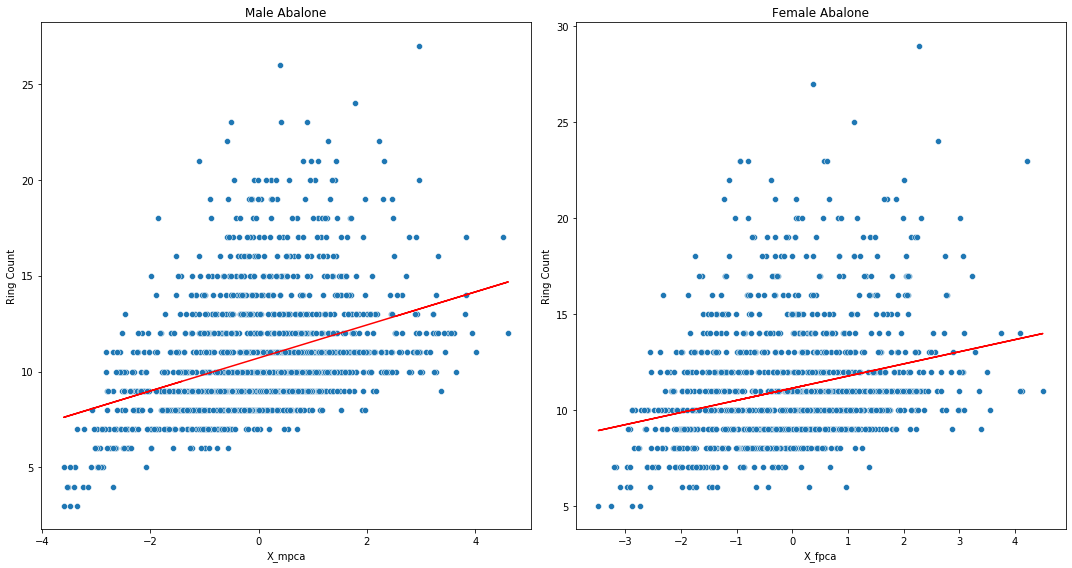

In [22]:
# Visualization of ring count with the first Principal Component as the independent variable.
red_msp = pd.DataFrame(index = Aba_data_male.index, columns = ['X_mpca', 'Ring Count'])
red_msp['X_mpca'] = X_mpca
red_msp['Ring Count'] = Aba_data_male['Ring Count']

red_fsp = pd.DataFrame(index = Aba_data_female.index, columns = ['X_fpca', 'Ring Count'])
red_fsp['X_fpca'] = X_fpca
red_fsp['Ring Count'] = Aba_data_female['Ring Count']

fig, axs = plt.subplots(1, 2, figsize = (15, 8))

sns.scatterplot(data = red_msp, x = 'X_mpca', y = 'Ring Count', ax = axs[0]).set_title('Male Abalone')
sns.scatterplot(data = red_fsp, x = 'X_fpca', y = 'Ring Count', ax = axs[1]).set_title('Female Abalone')

axs[0].plot(red_msp['X_mpca'], beta_hatm[0] + beta_hatm[1]*red_msp['X_mpca'], color = 'r')
axs[1].plot(red_fsp['X_fpca'], beta_hatf[0] + beta_hatf[1]*red_fsp['X_fpca'], color = 'r')

plt.tight_layout()
plt.show()

#### Quantifying Data Point Influence on Regression

The regression line looks appropriate. It goes through the bulk of the data points, but I want to see if there are any outliers, and high leverage points that could produce wild predictions. For a single feature (PC1), it's easy to see if there are points that pull at the regression line, but with higher dimensional features of 3 or more, I'll need numerical methods and criterions to assess such points.
<br>
Cook's Distance could come in handy here to discern changes of predicted age values; it's used to determine how much the average predicted ring count will change if any outlying observation of the recorded responses is omitted in the regression.

In [23]:
# Convert standardize design matrix to numpy array for matrix multiplication.
ckm = X_mreg.to_numpy()
ckf = X_freg.to_numpy()

# Hat matrix for future calculations.
H_male =  ckm @ la.inv(ckm.T @ ckm) @ ckm.T
H_female = ckf @ la.inv(ckf.T @ ckf) @ ckf.T

# Diagonal entries of male and female Hat matrix.
H_mdiag = pd.Series(H_male.diagonal())
H_fdiag = pd.Series(H_female.diagonal())

display(H_mdiag, H_fdiag)

0       0.001379
1       0.002741
2       0.001351
3       0.001290
4       0.001683
          ...   
1523    0.000709
1524    0.000680
1525    0.000655
1526    0.000789
1527    0.002973
Length: 1528, dtype: float64

0       0.001245
1       0.001052
2       0.001053
3       0.000853
4       0.001500
          ...   
1302    0.000768
1303    0.000769
1304    0.001477
1305    0.000833
1306    0.000795
Length: 1307, dtype: float64

In [24]:
# Mean Square Error is the sum of squared distances from the regression line to the actual observation point at the particular 'x-value'.
y_m = Aba_data_male['Ring Count'].to_numpy()
y_f = Aba_data_female['Ring Count'].to_numpy()

MSE_male = y_m.T @ (np.identity(len(H_male)) - H_male) @ y_m
MSE_female = y_f.T @ (np.identity(len(H_female)) - H_female) @ y_f

display("Mean Squares Error - Male", MSE_male, "Mean Squares Error - Female", MSE_female)

'Mean Squares Error - Male'

11918.390024359061

'Mean Squares Error - Female'

11678.347182076832

In [25]:
# Raw Residuals.
res_mraw = pd.Series(index = Aba_data_male.index)
res_fraw = pd.Series(index = Aba_data_female.index)

for r in res_mraw.index:
    res_mraw.loc[r] = red_msp.loc[r, 'Ring Count'] - (beta_hatm[0] + beta_hatm[1]*red_msp.loc[r, 'X_mpca'])
    
for r in res_fraw.index:
    res_fraw.loc[r] = red_fsp.loc[r, 'Ring Count'] - (beta_hatm[0] + beta_hatm[1]*red_fsp.loc[r, 'X_fpca'])
    
display(res_mraw, res_fraw)

0       5.518607
1      -1.628506
2       0.494720
3      -0.559410
4       0.752479
          ...   
1523   -0.371076
1524   -2.474446
1525   -0.684080
1526   -2.233643
1527   -0.894811
Length: 1528, dtype: float64

0      -0.809363
1       9.987404
2       5.988986
3       8.678509
4       4.403418
          ...   
1302    0.226493
1303    0.370633
1304   -1.614017
1305    0.630546
1306   -0.927858
Length: 1307, dtype: float64

In [26]:
# Creating empty dataframe for Cook's Distance calculations.
cook_m = pd.DataFrame(index = Aba_data_male.index, columns = ['Residual', 'Hat Diagonal', 'r-Square', "Cook's Distance"])
cook_f = pd.DataFrame(index = Aba_data_female.index, columns = ['Residual', 'Hat Diagonal', 'r-Square', "Cook's Distance"])

# Inserting residuals into the once empty dataframe.
cook_m['Residual'] = res_mraw
cook_f['Residual'] = res_fraw

# Inserting the diagonal of the projection matrix into dataframe.
cook_m['Hat Diagonal'] = H_mdiag
cook_f['Hat Diagonal'] = H_fdiag

# The number of predictor variables used in the OLS.
k = 1

# Computing the remaining r-Square values and Cook's Distance.
for i in cook_m.index:
    cook_m.loc[i, 'r-Square'] = (cook_m.loc[i, 'Residual'] / math.sqrt(MSE_male * (1 - cook_m.loc[i, 'Hat Diagonal'])))**2
    cook_m.loc[i, "Cook's Distance"] = (cook_m.loc[i, 'r-Square'] / (k + 1)) * (cook_m.loc[i, 'Hat Diagonal'] / (1 - cook_m.loc[i, 'Hat Diagonal']))

for j in cook_f.index:
    cook_f.loc[j, 'r-Square'] = (cook_f.loc[j, 'Residual'] / math.sqrt(MSE_female * (1 - cook_f.loc[j, 'Hat Diagonal'])))**2
    cook_f.loc[j, "Cook's Distance"] = (cook_f.loc[j, 'r-Square'] / (k + 1)) * (cook_f.loc[j, 'Hat Diagonal'] / (1 - cook_f.loc[j, 'Hat Diagonal']))

# Cook's Distance is compared to the 50th percentile of an F-distribution with parameters of (df1 = k + 1, df2 = n - (k + 1)).
q_m50 = st.f.ppf(.5, k + 1, len(cook_m) - (k + 1))
q_f50 = st.f.ppf(.5, k + 1, len(cook_f) - (k + 1))

# Here I'm being more stringent with the cut off point in evaluating if a Cook's Distance value is greater than the 20th percentile as being influential.
q_m20 = st.f.ppf(.2, k + 1, len(cook_m) - (k + 1))
q_f20 = st.f.ppf(.2, k + 1, len(cook_f) - (k + 1))

display("Cook's Distance - Male", cook_m, "Cook's Distance - Female", cook_f)
display(cook_m[cook_m["Cook's Distance"] > q_m20])
display(cook_f[cook_f["Cook's Distance"] > q_f20])

"Cook's Distance - Male"

,Residual,Hat Diagonal,r-Square,Cook's Distance
0,5.518607,0.001379,0.00255883,1.7672e-06
1,-1.628506,0.002741,0.000223128,3.06681e-07
2,0.494720,0.001351,2.05631e-05,1.39127e-08
3,-0.559410,0.001290,2.62908e-05,1.69781e-08
4,0.752479,0.001683,4.75886e-05,4.01086e-08
...,...,...,...,...
1523,-0.371076,0.000709,1.15616e-05,4.0989e-09
1524,-2.474446,0.000680,0.000514084,1.74979e-07
1525,-0.684080,0.000655,3.92899e-05,1.28694e-08
1526,-2.233643,0.000789,0.000418941,1.65485e-07


"Cook's Distance - Female"

,Residual,Hat Diagonal,r-Square,Cook's Distance
0,-0.809363,0.001245,5.61624e-05,3.49977e-08
1,9.987404,0.001052,0.00855029,4.50163e-06
2,5.988986,0.001053,0.00307456,1.62074e-06
3,8.678509,0.000853,0.00645475,2.7559e-06
4,4.403418,0.001500,0.00166284,1.24865e-06
...,...,...,...,...
1302,0.226493,0.000768,4.39603e-06,1.68909e-09
1303,0.370633,0.000769,1.17718e-05,4.5272e-09
1304,-1.614017,0.001477,0.000223397,1.65184e-07
1305,0.630546,0.000833,3.40732e-05,1.41958e-08


,Residual,Hat Diagonal,r-Square,Cook's Distance


,Residual,Hat Diagonal,r-Square,Cook's Distance


The empty dataframes show that there are no outlying response points based on the average residual. The graphics support this notion. The distance between the predicted age and observed age at a particular 'X_mpca' / 'X_fpca' value is within the average observed distances, so I will not see any large Cook's Distance values. I conclude based on the lack of results, there are no response variable outliers for either data sets.
<br>

I want to determine next if the predictor variable has outliers that affect the regression coefficient with the use of DFBETA method. This technique is a measure of the estimation of regression coefficients with a data point out. Looping through the entire data using this method, I can see what the difference is for all entries taken out one at a time. If the regression line changes drastically, then that omitted point could be influential. 

In [27]:
DFBETA_m = pd.DataFrame(index = Aba_data_male.index, columns = ['X_mpca', 'Ring Count', 'Intercept', 'Slope'])
DFBETA_f = pd.DataFrame(index = Aba_data_female.index, columns = ['X_fpca', 'Ring Count', 'Intercept', 'Slope'])

DFBETA_m['X_mpca'] = X_mpca
DFBETA_f['X_fpca'] = X_fpca

DFBETA_m['Ring Count'] = Aba_data_male['Ring Count']
DFBETA_f['Ring Count'] = Aba_data_female['Ring Count']

gram_invm = la.inv(X_mreg.T @ X_mreg)
gram_invf = la.inv(X_freg.T @ X_freg)

for i in DFBETA_m.index:
    DFBETA_m.loc[i, ['Intercept', 'Slope']] = (gram_invm @ X_mreg.iloc[i].T * res_mraw.iloc[i]) / (1 - X_mreg.iloc[i] @ gram_invm @ X_mreg.iloc[i].T)
    
for i in DFBETA_f.index:
    DFBETA_f.loc[i, ['Intercept', 'Slope']] = (gram_invf @ X_freg.iloc[i].T * res_fraw.iloc[i]) / (1 - X_freg.iloc[i] @ gram_invf @ X_freg.iloc[i].T)

display("DFBETA Table - Male", DFBETA_m, "DFBETA Table - Female", DFBETA_f)

'DFBETA Table - Male'

,X_mpca,Ring Count,Intercept,Slope
0,-1.42153,15,0.00361664,-0.00281807
1,-2.41197,7,-0.00106871,0.00141293
2,-1.39379,10,0.000324208,-0.000247692
3,-1.33093,9,-0.000366579,0.000267432
4,-1.69312,10,0.00049329,-0.000457806
...,...,...,...,...
1523,-0.388357,10,-0.000243023,5.17332e-05
1524,-0.268315,8,-0.0016205,0.000238335
1525,-0.0248711,10,-0.00044799,6.10737e-06
1526,0.613325,9,-0.00146296,-0.000491831


'DFBETA Table - Female'

,X_fpca,Ring Count,Intercept,Slope
0,-1.04066,9,-0.000620024,0.000373501
1,-0.804653,20,0.00764952,-0.003563
2,-0.80649,16,0.00458707,-0.00214144
3,-0.445939,19,0.00664569,-0.00171549
4,-1.28776,14,0.00337416,-0.00251521
...,...,...,...,...
1302,0.0789785,11,0.000173425,7.92856e-06
1303,-0.088409,11,0.000283794,-1.45235e-05
1304,-1.26751,8,-0.00123673,0.000907402
1305,-0.39024,11,0.000482839,-0.00010907


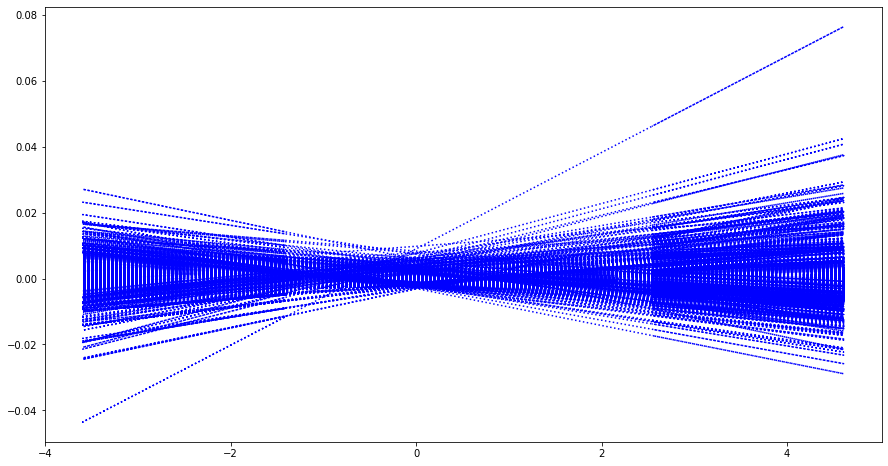

In [28]:
# Create plot for male abalone regression lines.
fig, axs = plt.subplots(figsize = (15, 8))
dfb_m = sns.scatterplot()

# Looping through DFBETA_m dataframe to plot slope and intercept.
for m in DFBETA_m.index:
    plt.plot(DFBETA_m['X_mpca'], DFBETA_m.loc[m, 'Intercept'] + DFBETA_m.loc[m, 'Slope']*DFBETA_m['X_mpca'], color = 'b', linestyle = ':')

plt.show()

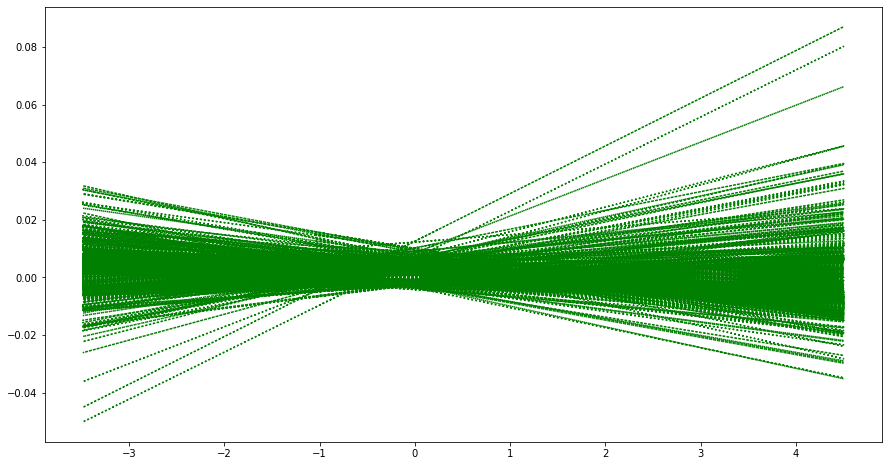

In [29]:
# Create plot for female abalone regression lines.
fig, axs = plt.subplots(figsize = (15, 8))
dfb_f = sns.scatterplot()

# Looping through DFBETA_f dataframe to plot slope and intercept.
for f in DFBETA_f.index:
    plt.plot(DFBETA_f['X_fpca'], DFBETA_f.loc[f, 'Intercept'] + DFBETA_f.loc[f, 'Slope']*DFBETA_f['X_fpca'], color = 'g', linestyle = ':')

plt.show()

In [30]:
# Computing critical cut-off threshold for omission.
DFB_critm = 2/math.sqrt(len(DFBETA_m))
DFB_critf = 2/math.sqrt(len(DFBETA_f))

# Initialize empty list for index storage.
DFB_ptm = []
DFB_ptf = []

# Looping through the DFBETA results to find values greater than the critical cut-off point.
for m in DFBETA_m.index:
    if DFBETA_m.loc[m, 'Slope'] > DFB_critm:
        DFB_ptm.append(m)
        
for f in DFBETA_f.index:
    if DFBETA_f.loc[f, 'Slope'] > DFB_critf:
        DFB_ptf.append(f)
        
display(DFB_ptm, DFB_ptf)

[]

[]

The empty lists mean no predictor variable outliers. I would like to check next how extreme predictor values without neighboring points affect the regression by calculating leverage. The idea is that if a data point has high leverage, then the mathematics behind the regression will try to accommodate the point by having the regression line pass near it and the bulk of the data points. 

'Male Leverage Omission Line'

0.003926701570680628

'Female Leverage Omission Line'

0.0045906656465187455

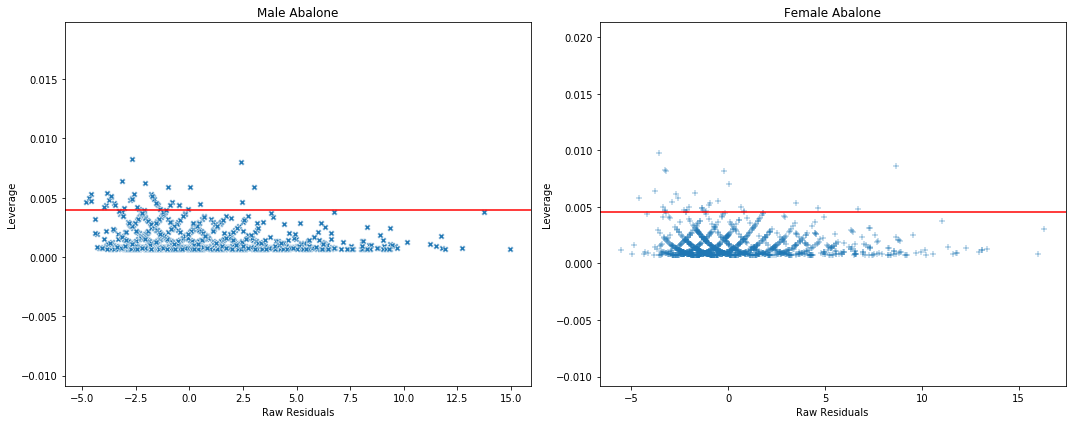

In [31]:
# Number of predictor variables.
k = 1

# Computing cut-off threshold for high leverage data points.
prex_m = 3*(k+1)/len(DFBETA_m)
prex_f = 3*(k+1)/len(DFBETA_f)

display("Male Leverage Omission Line", prex_m,"Female Leverage Omission Line", prex_f)

fig, axs = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(x = res_mraw, y = H_mdiag, marker = 'X', ax = axs[0])
sns.scatterplot(x = res_fraw, y = H_fdiag, marker = '+', ax = axs[1])

axs[0].axhline(y = prex_m, color = 'r', linestyle = '-')
axs[1].axhline(y = prex_f, color = 'r', linestyle = '-')

axs[0].set_xlabel('Raw Residuals')
axs[0].set_ylabel('Leverage')
axs[0].set_title('Male Abalone')

axs[1].set_xlabel('Raw Residuals')
axs[1].set_ylabel('Leverage')
axs[1].set_title('Female Abalone')

plt.tight_layout()

plt.show()

#### Regression with Omitted High Leverage Points

In [32]:
X_momit = Aba_data_male
X_fomit = Aba_data_female

m_omitlist = []
f_omitlist = []

for i in H_mdiag.index:
    if H_mdiag.iloc[i] > prex_m:
        m_omitlist.append(i)

for j in H_fdiag.index:
    if H_fdiag.iloc[j] > prex_f:
        f_omitlist.append(j)
        
X_momit = X_momit.drop(m_omitlist).reset_index(drop = True)
X_fomit = X_fomit.drop(f_omitlist).reset_index(drop = True)

Y_momit = X_momit['Ring Count']
Y_fomit = X_fomit['Ring Count']

X_momit = X_momit.drop(columns = ['Ring Count'])
X_fomit = X_fomit.drop(columns = ['Ring Count'])

pca_var = ['Length', 'Diameter', 'Height', 'Whole Weight']

z_momit = pd.DataFrame(index = X_momit.index, columns = pca_var)
z_fomit = pd.DataFrame(index = X_fomit.index, columns = pca_var)

for var in pca_var:
    for i in z_momit.index:
        z_momit.loc[i, var] = (X_momit.loc[i, var] - X_momit[var].mean()) / (X_momit[var].std())
        
for var in pca_var:
    for i in z_fomit.index:
        z_fomit.loc[i, var] = (X_fomit.loc[i, var] - X_fomit[var].mean()) / (X_fomit[var].std())

cov_momit = X_momit.cov()
cov_fomit = X_fomit.cov()

display("Male - Omitted Covariance Matrix", cov_momit, "Female - Omitted Covariance Matrix", cov_fomit)

'Male - Omitted Covariance Matrix'

,Length,Diameter,Height,Whole Weight
Length,354.151472,285.169137,97.561116,1503.810380
Diameter,285.169137,239.947439,81.211590,1228.233019
Height,97.561116,81.211590,39.045357,457.277362
Whole Weight,1503.810380,1228.233019,457.277362,7383.114814


'Female - Omitted Covariance Matrix'

,Length,Diameter,Height,Whole Weight
Length,266.615920,212.260998,66.405285,1212.742439
Diameter,212.260998,180.499683,55.616200,993.656795
Height,66.405285,55.616200,61.597759,347.743797
Whole Weight,1212.742439,993.656795,347.743797,6341.910875


In [33]:
eig_momit, eigv_momit = la.eig(cov_momit)
eig_fomit, eigv_fomit = la.eig(cov_fomit)

# Rerepresenting the original data set by a reduced linear combination equivalent based on the first Principal Component acting as the scalar weights multiplied with the predictor variables.
O_fpca = pd.Series(z_fomit @ eigv_fomit[:, 0]) 
O_mpca = pd.Series(z_momit @ eigv_momit[:, 0])

# Create design matrix for OLS regression.
O_mreg = pd.DataFrame(index = O_mpca.index, columns = ['Ones', 'O_mpca'])
O_freg = pd.DataFrame(index = O_fpca.index, columns = ['Ones', 'O_fpca'])

# Populating the "ones" column with "1's".
O_mreg['Ones'] = 1
O_freg['Ones'] = 1

# Inserting the series containing the principal component into the remaining column.
# Converted the object series to float data type enabling invocation of "la.inv()" method.
O_mreg['O_mpca'] = O_mpca.astype(float).to_numpy()
O_freg['O_fpca'] = O_fpca.astype(float).to_numpy()

#display(Y_momit)

display("Eigenvalues - Omitted Male", eig_momit.real, "Eigenvectors (Column Vectors) - Omitted Male", eigv_momit, "Eigenvalues - Omitted Female", eig_fomit.real, "Eigenvectors (Column Vectors) - Omitted Female", eigv_fomit)

'Eigenvalues - Omitted Male'

array([7.92733008e+03, 7.26773822e+01, 5.92139083e+00, 1.03302296e+01])

'Eigenvectors (Column Vectors) - Omitted Male'

array([[ 0.19844792,  0.73462185, -0.60421166, -0.23638408],
       [ 0.16213508,  0.62059995,  0.75540013,  0.13393491],
       [ 0.06004882,  0.08498116, -0.2532339 ,  0.96179256],
       [ 0.96474078, -0.2607003 ,  0.01309583, -0.03375013]])

'Eigenvalues - Omitted Female'

array([6751.75207616,    6.94424528,   49.50207906,   42.42583751])

'Eigenvectors (Column Vectors) - Omitted Female'

array([[ 0.1867514 ,  0.62512693,  0.75752536,  0.02226131],
       [ 0.15300175, -0.78007506,  0.60648274, -0.01587609],
       [ 0.05348981,  0.026414  , -0.00565011, -0.99820299],
       [ 0.96894438,  0.00123499, -0.24145826,  0.05332135]])

In [ ]:
beta_hatmomit = la.inv(O_mreg.T @ O_mreg) @ O_mreg.T @ Y_momit
beta_hatfomit = la.inv(O_freg.T @ O_freg) @ O_freg.T @ Y_fomit

omit_msp = pd.DataFrame(index = O_mreg.index, columns = ['O_mpca','Ring Count'])
omit_fsp = pd.DataFrame(index = O_freg.index, columns = ['O_fpca','Ring Count'])

omit_msp['O_mpca'] = O_mreg['O_mpca']
omit_msp['Ring Count'] = Y_momit

omit_fsp['O_fpca'] = O_freg['O_fpca']
omit_fsp['Ring Count'] = Y_momit

fig, axs = plt.subplots(2, 2, figsize = (15, 10))

sns.scatterplot(data = omit_msp, x = omit_msp['O_mpca'], y = omit_msp['Ring Count'], ax = axs[0, 0]).set_title('Male Abalone WITH Omissions')
sns.scatterplot(data = omit_fsp, x = omit_fsp['O_fpca'], y = omit_fsp['Ring Count'], ax = axs[0, 1]).set_title('Female Abalone WITH Omissions')

axs[0, 0].plot(O_mreg['O_mpca'], beta_hatmomit[0] + beta_hatmomit[1]*O_mreg['O_mpca'], color = 'r')
axs[0, 1].plot(O_freg['O_fpca'], beta_hatfomit[0] + beta_hatfomit[1]*O_freg['O_fpca'], color = 'r')

sns.scatterplot(data = red_msp, x = 'X_mpca', y = 'Ring Count', ax = axs[1, 0]).set_title('Male  Abalone W/O Omissions')
sns.scatterplot(data = red_fsp, x = 'X_fpca', y = 'Ring Count', ax = axs[1, 1]).set_title('Female Abalone W/O Omissions')

axs[1, 0].plot(red_msp['X_mpca'], beta_hatm[0] + beta_hatm[1]*red_msp['X_mpca'], color = 'r')
axs[1, 1].plot(red_fsp['X_fpca'], beta_hatf[0] + beta_hatf[1]*red_fsp['X_fpca'], color = 'r')

axs[0, 0].annotate('y = 10.74 + 0.77x', xy=(1, 0), xycoords='axes fraction', fontsize=16,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')

axs[0, 1].annotate('y = 11.12 + 0.56x', xy=(1, 0), xycoords='axes fraction', fontsize=16,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')

axs[1, 0].annotate('y = 10.7 + 0.86x', xy=(1, 0), xycoords='axes fraction', fontsize=16,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')

axs[1, 1].annotate('y = 11.12 + 0.63x', xy=(1, 0), xycoords='axes fraction', fontsize=16,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')

plt.tight_layout()
plt.show()

#display(beta_hatm, beta_hatmomit, beta_hatf, beta_hatfomit)

The regression plots with and without omitted data points show no outlying points in either the predictor variable or response variable. I have no reasonable explanation on why I would omit data points and throwing those points away would discard revelant information. I am going to use the estimated regression coefficients without omitting data points.

## Residual Analysis

Residuals are how far off the predicted ring count is from the actual observed ring count. It's an important statistic used to determine if there are violations that would make the linear regression invalid. There are 3 common criteria that use residuals to determine assumptions violations with 1 additional assumption necessary for testing.
<br>

1. The linearity assumption requires that the regression line is a linear combination of a single unknown parameter, $\beta$, multiplied with predictor variables to return a average predicted ring count.
<br>

    $y = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} +...+ \beta_{n}x_{n}$, <--- This is what I want to see.
<br>

    $y = \beta_{0}\beta_{1} + \beta_{1}\beta_{2}x_{1} + \beta_{2}\beta_{3}x_{2} +...+ \beta_{n}\beta_{n-1}x_{n}$, <--- Violation of the linearity assumption.
<br>

2. The second assumption is that the residuals should be independent of the predictor variables meaning a plot of residuals and predicted ring count should show no discernable trends or patterns.
<br>
3. The third assumption is residuals are normally distributed. This assumption is needed for significance testing to be valid.
<br>
4. The fourth assumption is the variance of the residual should be constant. If this assumption is violated, then I would need to start over with a generalized linear model that takes into account non-normally distributed residuals.


#### Linearity and Normality Check

In [ ]:
#Plotting raw residuals versus fitted values for both dataframes.
resp_m = pd.DataFrame(index = res_mraw.index, columns = ['Residual', 'Fitted Value'])
resp_f = pd.DataFrame(index = res_fraw.index, columns = ['Residual', 'Fitted Value'])

resp_m['Residual'] = res_mraw
resp_f['Residual'] = res_fraw

for r in resp_m.index:
     resp_m.loc[r, 'Fitted Value'] = (beta_hatm[0] + beta_hatm[1]*red_msp.loc[r, 'X_mpca'])
    
for r in resp_f.index:
     resp_f.loc[r, 'Fitted Value'] = (beta_hatm[0] + beta_hatm[1]*red_fsp.loc[r, 'X_fpca'])

fig, axs = plt.subplots(3, 2, figsize = (15, 15))

axs[0, 0].axhline(y = 0, color = 'black', linestyle = '-')
axs[0, 1].axhline(y = 0, color = 'black', linestyle = '-')

sns.scatterplot(data = resp_m, x = resp_m['Fitted Value'], y = resp_m['Residual'], ax = axs[0, 0])
sns.scatterplot(data = resp_f, x = resp_f['Fitted Value'], y = resp_f['Residual'], ax = axs[0, 1])

sns.histplot(data = resp_m, x = resp_m['Residual'], stat = 'density', kde = True, ax = axs[1, 0])
sns.histplot(data = resp_f, x = resp_f['Residual'], stat = 'density', kde = True, ax = axs[1, 1])

qqplot_m = st.probplot(x = resp_m['Residual'], dist = st.norm, plot = axs[2, 0])
qqplot_f = st.probplot(x = resp_f['Residual'], dist = st.norm, plot = axs[2, 1])

plt.tight_layout()
plt.show()

In [ ]:
# Shapiro-Wilk Normality test on residuals
# Null hypothesis is that the residuals come from a normal distribution. If p-value is less than 0.05, data are not from normal distribution.
# SciPy documentation lists the alpha level to be 5%.
w_f, pval_f = st.shapiro(resp_f['Residual'])
w_m, pval_m = st.shapiro(resp_m['Residual'])

display("Female p-value", pval_f, "Male p-value", pval_m)

Plotting the residuals versus fitted values show no discernable pattern between either the male or female data set. They also tend to be centered around 0 which implies the linear assumption is valid. I still need to verify it numerically as judging with the eye is subjective. The density scaled histograms suggest a Gamma density function. The QQ plots are most striking in telling that the residuals are not normally distributed. 
<br>

I would like to chase down my hunch that the residuals are Gamma distributed by plotting the theoretical quantiles from a Gamma distribution compared to the quantized data.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 8))

qqplot_m = st.probplot(x = resp_m['Residual'], dist = st.gamma, sparams = (2.5,), plot = axs[0])
qqplot_f = st.probplot(x = resp_f['Residual'], dist = st.gamma, sparams = (2.5,), plot = axs[1])

#### Homoscedasticity Check

In [ ]:
# Using Stats Model library function to set up OLS.
model_m = sm.OLS(red_msp['Ring Count'], X_mreg)
model_f = sm.OLS(red_fsp['Ring Count'], X_freg)

# Label results of the fit to access related information.
results_m = model_m.fit()
results_f = model_f.fit()

#display(results_m.summary())
#display(results_f.summary())

# Breusch-Pagan Heteroscedasticity Test.
BP_test_m = sm.stats.diagnostic.het_breuschpagan(results_m.resid, results_m.model.exog)
BP_test_f = sm.stats.diagnostic.het_breuschpagan(results_f.resid, results_f.model.exog)

display("male p-value", BP_test_m[1], "female p-value", BP_test_f[1])

The BP test statistics come back indicating the female abalone residuals have constant variance, but the male abalone residuals are not! Since the assumption that residuals are normally distributed are violated significance testing for the estimated regression coefficients of $\beta_{0}$ $\neq$ $\beta_{1}$ $\neq$ 0 can not be trusted.

## Conclusion

I began the study with the mindset of first getting an initial read of the data. What are the variables, what are the data types, and how does it all look like? This embodies the mindset that is exploratory data analysis. I separated the data set into 3: male, female, and infant. Computing tables of summary statistics with the matrix of scatterplots, and boxplots, I suspected collinearity issues with the predictor variables of length, diameter, height, and whole weight. I followed up my suspicion with numerically assessing collinearity by using correlation coefficients and Variance Inflated Factors. The returned values confirmed the predictors were linked to one another which makes it difficult to predict ring count. 
<br>

The solution I came up with to address the multicollinearity of the predictor variable was to use PCA to untangle them. The added bonus of using PCA was the first principal component captured over 98% of the variance, or "information" of the data, reducing the original 4 predictor variables down to 1. The next step before running regression was to determine if the two data sets were statistically different from one another, that is, are female abalone different from male abalone? To answer this question, I used a test of two populations, one of female abalone and one of male abalone, with the null hypothesis that the predictor variable means were the same. The probability values for the significance test were less than the $\alpha$-level which meant the male abalone were physically different from their female counterparts. For a better fit, I decided to apply regression separately to each dataframe.
<br>

I verified that there were no outliers in either the response variable or predictor variable that would unduly pull at the regression line choosing to use the rerepresented data via recast without omitting any data points.
<br>

Checking the assumptions on what makes regression valid using residual analysis, the normality and homoscedasticity assumptions were not fulfilled for the male regression fit. The female regression fit only had the normality assumption being invalid. The consequence of these two assumptions violated means that the fit for the male abalone can't be trusted because the non-constant residual variances suggest the OLS line failed to capture the underlying relationship between ring count and physical features while the female regression line can be used to predict age, but testing for non-zero coefficient estimates can't be done due to the residuals not being normally distributed. The notion that male and female abalone are different is supported here by the non-constant variance of residuals in the male regression. 
<br>

Unfornutaley, I've used all the data to fit my regression which leaves none for testing purposes. Future projects will have this in mind with cross validation for better parameter estimation. If I did get new data from the same area, I would subtract the mean and divide by the standard deviation of original data sets then multiply the standardized values of length, diameter, height, and whole weight by the first principal component to convert it into the PC1 variable. After completing the analysis, and reading the fisheries report, I suspect that the current data collected here is not sufficient to accurately predict age. The large residuals and low correlation for both dataframes spur my inkling forward, but failure to strongly link an average age relationship to the current physical measurement attributes is still important information. This tells me that new variables that are more strongly correlated with ring count are needed to predict age.

$y_{male} = 10.7 + 0.86pc_{1}$ 
<br>

$y_{female} = 11.12 + 0.63pc_{1}$   
<br>
$pc_{1} = u_{1}x_{len.} + u_{2}x_{dia.} + u_{3}x_{ht.} + u_{4}x_{wt.}$
<br>
<br>
$u_{male} = \begin{bmatrix} 0.196  \\ 0.160 \\ 0.060 \\ 0.966 \end{bmatrix}$  
<br>
$u_{female} = \begin{bmatrix} 0.182  \\ 0.149 \\ 0.053 \\ 0.970 \end{bmatrix}$
<br>